DEEP REINFORCEMENT LEARNING EXPLAINED - 13
# **Monte Carlo Methods**
## Exploration-Explanation Dilemma

In [16]:
import sys
import gym
import numpy as np
from collections import defaultdict
env = gym.make('Blackjack-v0')
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [17]:
state = env.reset()
while True:
       print('state:', state)
       action = env.action_space.sample()
       print('action: ', action) 
       state, reward, done, info = env.step(action)
       if done:
          if reward > 0: 
             print('Reward: ', reward)                 
          else: 
             print('Reward: ', reward)
          break

state: (11, 6, False)
action:  0
Reward:  -1.0


In [18]:
def generate_episode(env):
    episode = []
    state = env.reset()
    while True:
        probs = [0.75, 0.25] if state[0] > 18 else [0.25, 0.75]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [19]:
for i in range(10):
    print(generate_episode(env))

[((7, 10, False), 1, 0.0), ((16, 10, False), 1, -1.0)]
[((16, 10, False), 1, -1.0)]
[((13, 9, False), 1, 0.0), ((16, 9, False), 1, -1.0)]
[((15, 10, False), 1, 0.0), ((19, 10, False), 0, -1.0)]
[((8, 10, False), 1, 0.0), ((14, 10, False), 1, -1.0)]
[((11, 10, False), 1, 0.0), ((18, 10, False), 1, -1.0)]
[((19, 10, False), 0, 1.0)]
[((16, 6, False), 1, -1.0)]
[((9, 6, False), 0, -1.0)]
[((15, 5, False), 1, -1.0)]


In [20]:
episode = generate_episode(env)
print (episode)
states, actions, rewards = zip(*episode)
print('states:  ',states)
print('actions: ', actions)
print('rewards: ', rewards)

[((17, 4, False), 1, -1.0)]
states:   ((17, 4, False),)
actions:  (1,)
rewards:  (-1.0,)


In [21]:
def mc_prediction(env, num_episodes, generate_episode, gamma=1.0):
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for episode in range(1, num_episodes+1):
        
        if episode % 10000 == 0: # monitor progress
            print("\repisode {}/{}.".format(episode, num_episodes), end="")
            sys.stdout.flush()
        
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)

        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [22]:
num_episodes=1000000

Q = mc_prediction(env, num_episodes, generate_episode)


episode 1000000/1000000.

In [23]:
for i in range(5):
  print(Q.popitem())

((4, 1, False), array([-0.7254902 , -0.66366366]))
((4, 7, False), array([-0.45454545, -0.45619335]))
((4, 3, False), array([-0.26315789, -0.38138138]))
((5, 6, False), array([-0.13656388, -0.32589286]))
((4, 5, False), array([-0.07936508, -0.36      ]))


In [24]:
State_Value_table={}
for state, actions in Q.items():
     State_Value_table[state]= (state[0]>18)*(np.dot([0.75, 0.25],actions)) + (state[0]<=18)*(np.dot([0.75, 0.25],actions))

In [25]:
# source: https://github.com/udacity/deep-reinforcement-learning/blob/master/monte-carlo/plot_utils.py

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()


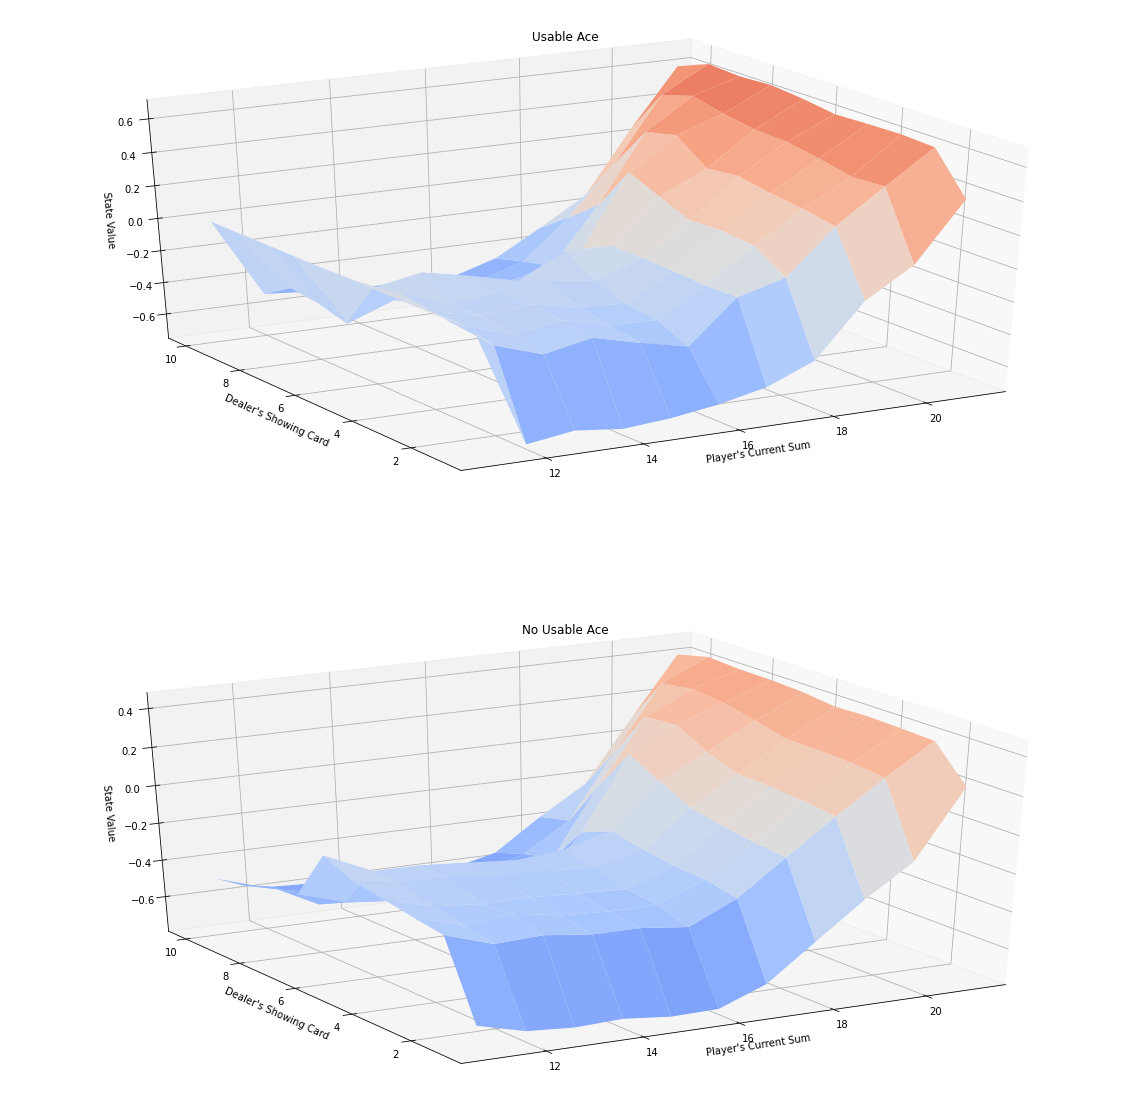

In [26]:
plot_blackjack_values(State_Value_table)

DEEP REINFORCEMENT LEARNING EXPLAINED - 14
# **MC Control Methods**
## Constant-α MC Control

In [27]:
import sys
import gym
import numpy as np
from collections import defaultdict

Example of setting the value of Epsilon

In [28]:
num_episodes=1000000

eps_start=1.0 
eps_decay=.9999965
eps_min=0.05

epsilon = eps_start
for episode in range(num_episodes):
        epsilon = max(epsilon*eps_decay, eps_min)
        if episode % 100000 == 0: print("Episode {} -> epsilon={}.".format(episode, epsilon))

Episode 0 -> epsilon=0.9999965.
Episode 100000 -> epsilon=0.7046851916863968.
Episode 200000 -> epsilon=0.4965829574224525.
Episode 300000 -> epsilon=0.3499358813150294.
Episode 400000 -> epsilon=0.24659549668667013.
Episode 500000 -> epsilon=0.17377280305645773.
Episode 600000 -> epsilon=0.12245554962615056.
Episode 700000 -> epsilon=0.08629291448656881.
Episode 800000 -> epsilon=0.060809551819579116.
Episode 900000 -> epsilon=0.05.


Constant-α MC Control algorithm : support functions

In [29]:
def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    max_action = np.argmax(Q_s)
    policy_s[max_action] = 1 - epsilon + (epsilon / nA)
    return policy_s
    
def generate_episode_from_Q(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:

        probs = get_probs(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs) if state in Q else env.action_space.sample()

        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode


def update_Q(env, episode, Q, alpha, gamma):
    
    states, actions, rewards = zip(*episode)

    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

Constant-α MC Control algorithm

In [30]:
def MC_control(env, num_episodes, alpha, eps_decay, gamma):
    eps_start=1.0
    eps_min=0.05

    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))

    epsilon = eps_start
    
    for episode in range(1, num_episodes+1):
        
        if episode % 1000 == 0: # monitor progress
            print("\rEpisode {}/{}.".format(episode, num_episodes), end="")
            sys.stdout.flush()

        epsilon = max(epsilon*eps_decay, eps_min)
        episode_generated = generate_episode_from_Q(env, Q, epsilon, nA)
        Q = update_Q(env, episode_generated, Q, alpha, gamma)
    policy = dict((state,np.argmax(actions)) for state, actions in Q.items())
    return policy, Q

In [31]:
env = gym.make('Blackjack-v0')
num_episodes=1000000
alpha = 0.02
eps_decay=.9999965 
gamma=1.0

policy, Q = MC_control(env, num_episodes, alpha, eps_decay, gamma)

Episode 1000000/1000000.

Plot of the state-value function.

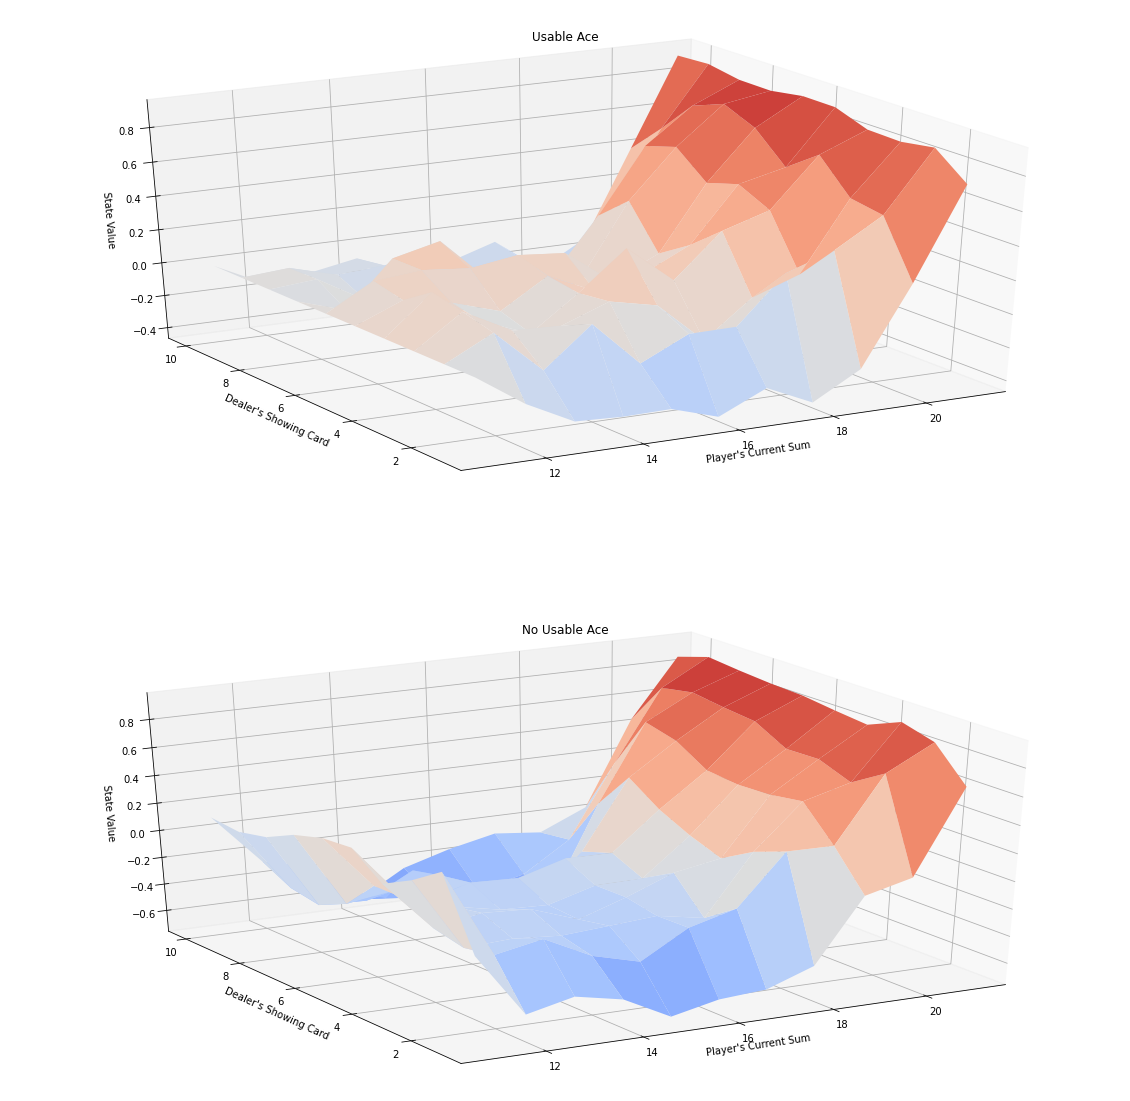

In [32]:
V = dict((state,np.max(actions)) for state, actions in Q.items())

plot_blackjack_values(V)